# Coffee Daily Price Per Pound

## Libraries and Packages

[Extract, Transform, Load (ETL) - Pandas](https://pandas.pydata.org/)

[Exploratory Analysis - Seaborn](https://seaborn.pydata.org/)

[Exploratory Analysis - Matplotlib](https://matplotlib.org/)

[Data Evaluation - Numpy](https://numpy.org/)

[Model and evaluate - Statsmodels](https://www.statsmodels.org/stable/index.html)

[Model and evaluate - Scikit-Learn](https://scikit-learn.org/stable/)

In [1]:
# Extract, Transform, Load (ETL)
import pandas as pd

# Data Evaluation
import numpy as np

# Exploratory Analysis
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (10,5)
import seaborn as sns
sns.set_style('darkgrid')


# Model and Evaluate
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error

# -- statsmodels.tsa - https://www.statsmodels.org/stable/tsa.html
# -- https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics


import warnings
warnings.filterwarnings('ignore')

## Loading Dataset
[Coffee Dataset Real Time](https://www.investing.com/commodities/us-coffee-c)

In [2]:
coffee_raw = pd.read_csv('../Data/coffee.csv')

In [3]:
coffee_raw.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-03,122.25,124.00,116.10,116.50,6640,USD
1,2000-01-04,116.25,120.50,115.75,116.25,5492,USD
2,2000-01-05,115.00,121.00,115.00,118.60,6165,USD
3,2000-01-06,119.00,121.40,116.50,116.85,5094,USD
4,2000-01-07,117.25,117.75,113.80,114.15,6855,USD


In [4]:
# Checking NA
coffee_raw.isna().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

## Data Wrangling

In [5]:
coffee_raw.Date = pd.to_datetime(coffee_raw.Date, yearfirst=True)
coffee_raw.set_index('Date', inplace = True)

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html
# b makes referance to Business Days 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
coffee = coffee_raw.asfreq('b', 'ffill')

## Exploratory Analysis

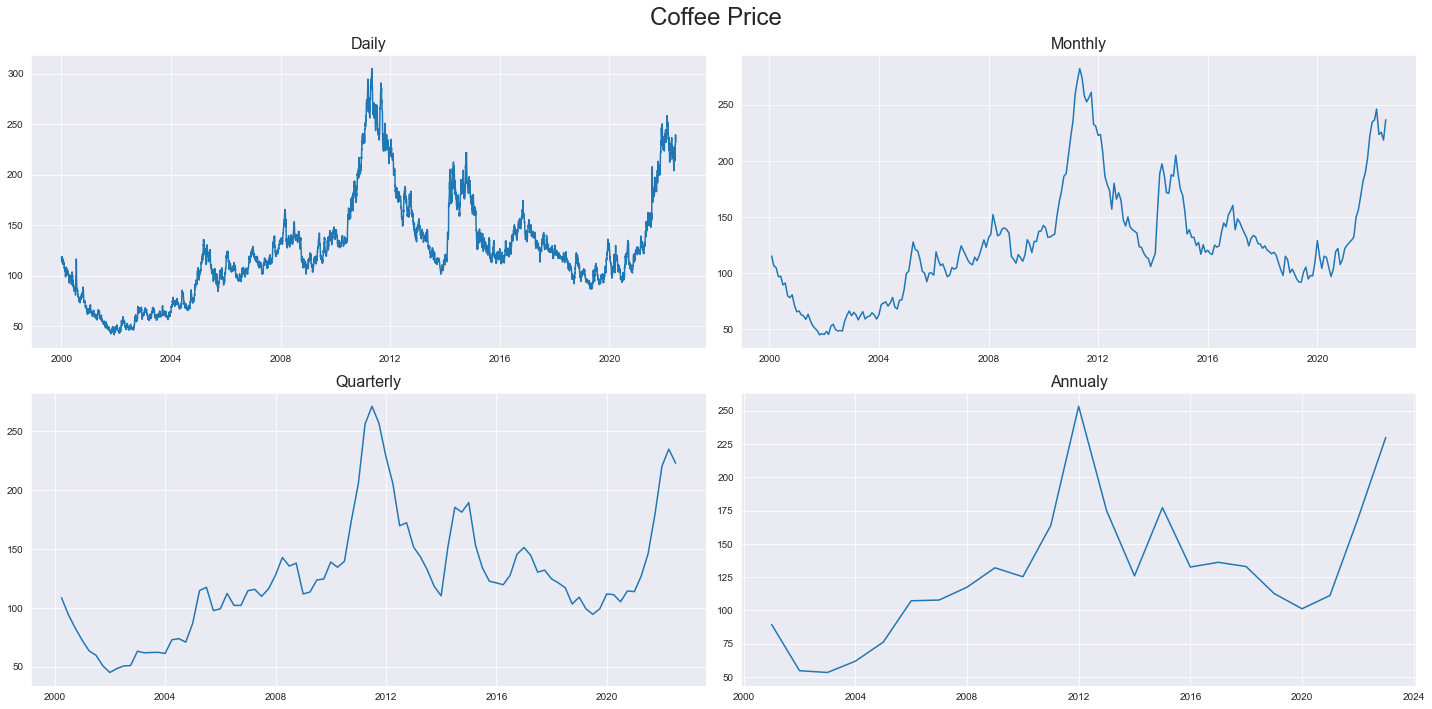

In [6]:
# Graphing

fig,axes = plt.subplots(2,2,figsize=[20,10])
fig.suptitle('Coffee Price',size=24)

## Resampling to Daily freq (Original Data)
axes[0,0].plot(coffee.Close)
axes[0,0].set_title("Daily",size=16)

## Resampling to Monthly freq 
axes[0,1].plot(coffee.Close.resample('M').mean())
axes[0,1].set_title("Monthly",size=16)

## Resmapling to Quarterly freq 
axes[1,0].plot(coffee.Close.resample('Q').mean())
axes[1,0].set_title('Quarterly',size=16)

## Resampling to Annualy freq
axes[1,1].plot(coffee.Close.resample('A').mean())
axes[1,1].set_title('Annualy',size=16)

plt.tight_layout()
plt.show()

### Using Statsmodels to analyse trending and seasonal prices
[statsmodels.seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

In [7]:
data_close_price = coffee.Close.resample('Q').mean()

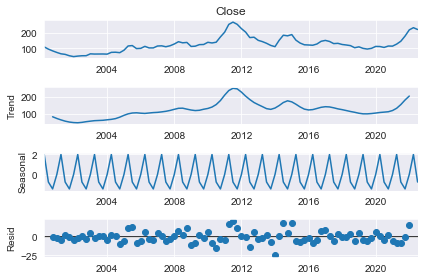

In [8]:
decompose_result = seasonal_decompose(data_close_price, model = 'additive')

## Systematic Components 
trend = decompose_result.trend
seasonal = decompose_result.seasonal

## Non-Systematic Components
residual = decompose_result.resid
decompose_result.plot();

## Stationarity

[Reference](https://www.indeed.com/career-advice/career-development/what-is-rolling-average)

In [9]:
def plot_rolling_stats(series, window=1):
    ## Calculating the Rolling Mean and Rolling Standard Deviation
    rol_mean = series.rolling(window).mean()
    rol_std  = series.rolling(window).std()
    
    ## ploting the results along side the original data
    fig = plt.figure(figsize=(10,5))
    orig = plt.plot(series,color='blue',label='Original')
    mean = plt.plot(rol_mean,color='red',label='Rolling mean')
    std  = plt.plot(rol_std,color='black',label='Rolling std')

    
    plt.title('Rolling Mean/Standard Deviation',size=20)
    plt.legend(loc='best')
    plt.show(block=False)

In [10]:
def stationarity_check(series):
    print('Results of Dickey Fuller Test:')
    coffee_test = adfuller(series, autolag='AIC') 

    coffee_output = pd.Series(coffee_test[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used','Number of Observations Used'])
    for key,value in coffee_test[4].items():
        coffee_output['Critical Value (%s)'%key] = value
        
    print(coffee_output)

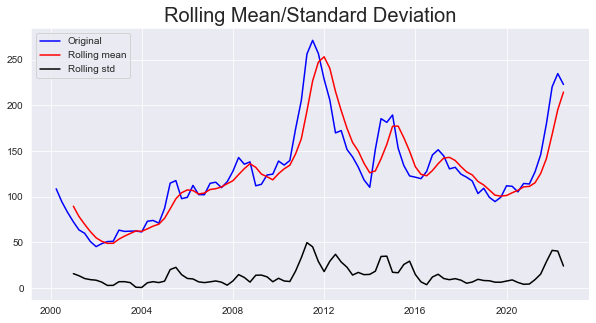

Results of Dickey Fuller Test:
Test Statistic                 -2.468513
p-value                         0.123325
#Lags Used                      1.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [11]:
## Original Data
plot_rolling_stats(data_close_price,4)
stationarity_check(data_close_price)

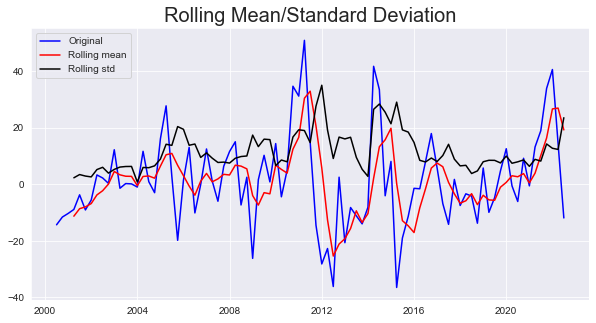

Results of Dickey Fuller Test:
Test Statistic                 -5.596658
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [12]:
## Regular Differentiation
plot_rolling_stats(data_close_price.diff()[1:],4)
stationarity_check(data_close_price.diff()[1:])

## Autocorrelation and Partial Autocorrelation

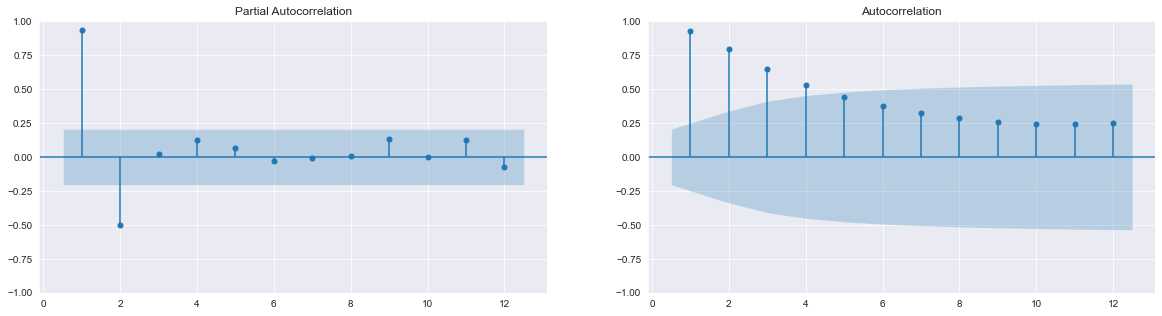

In [13]:
fig = plt.figure(figsize=(20,5))
ax_1 = fig.add_subplot(121)
plot_pacf(data_close_price,lags=12,zero=False,ax=ax_1)

ax_2 = fig.add_subplot(122)
plot_acf(data_close_price,lags=12,zero=False,ax=ax_2);

## Time Series Modeling

In [14]:
size = 0.8 ## train size
train, test = data_close_price.iloc[:int(size*len(data_close_price))], data_close_price.iloc[int(size*len(data_close_price)):]

### SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors)

In [15]:
model = SARIMAX(train,order=(2,1,2),seasonal_order=(1,1,1,4)).fit(disp=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                   72
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 4)   Log Likelihood                -278.794
Date:                             Sat, 09 Jul 2022   AIC                            571.588
Time:                                     18:04:42   BIC                            587.021
Sample:                                 03-31-2000   HQIC                           577.695
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4044      0.193      7.271      0.000       1.026       1.783
ar.L2         -0.5975      0.228     -2.623      0.009      -1.044      -0.151
ma.L1         -0.9982      0.269     -3.711      0.000      -1.525      -0.471
ma.L2          0.1952      0.291      0.670      0.503      -0.376       0.766
ar.S.L4       -0.1117      0.184     -0.606      0.545      -0.473       0.250
ma.S.L4       -0.9851      1.158     -0.851      0.395      -3.254       1.284
sigma2       198.7446    215.337      0.923      0.356    -223.309     620.798
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.91   Prob(JB):                         0.44
Heteroskedasticity (H):               3.26   Skew:                            -0.30
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

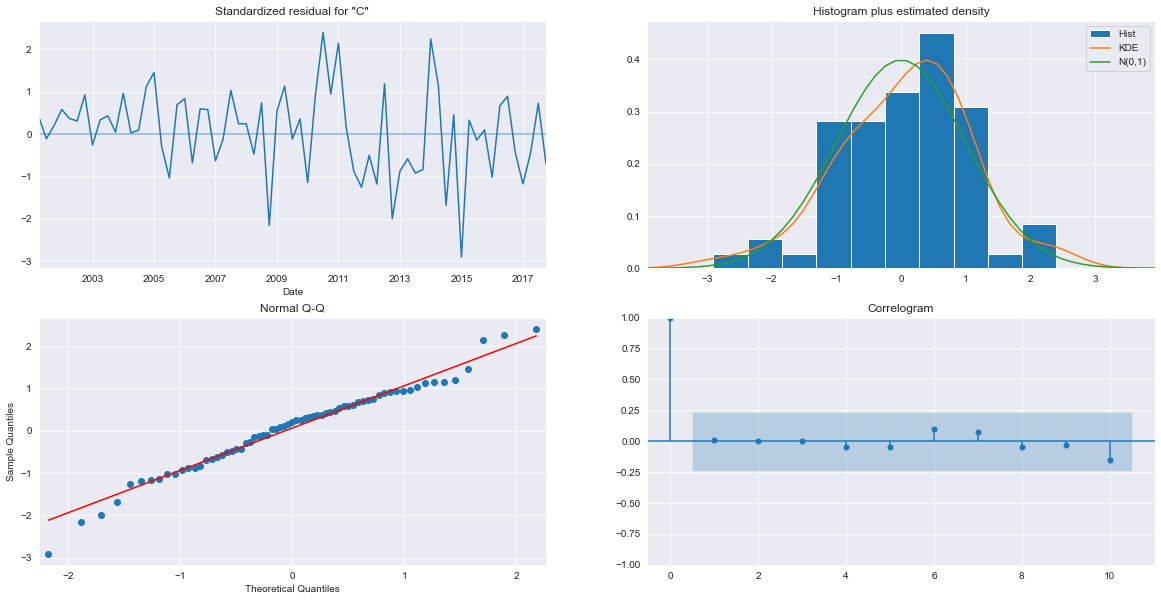

In [16]:
model.plot_diagnostics(figsize=(20,10))
plt.show()

## Predictions

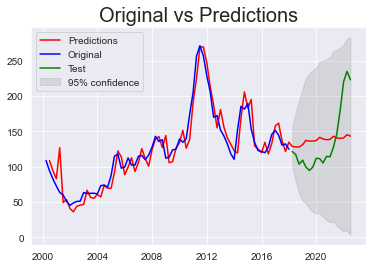

In [17]:
predictions = model.get_prediction(start='2000-03-31',end='2022-06-30')
conf = predictions.conf_int()
test_conf = conf.loc[test.index[0]:]
## Ploting results
plt.plot(predictions.predicted_mean[1:],color='red',label='Predictions')
plt.plot(train,color='blue',label='Original')
plt.plot(test,color='green',label='Test')
plt.fill_between(test_conf.index, test_conf.iloc[:,0], test_conf.iloc[:,1], color='gray', alpha=.2,label='95% confidence')
plt.title('Original vs Predictions',size=20)
plt.legend(loc='best');

## Accuracy Metrics

[scikit.metrics.mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)

[scikit.metrics.mean_absolute_percentage_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html)

In [18]:
print(f"Mean Absolute Error: {mean_absolute_error(data_close_price[1:],predictions.predicted_mean[1:])}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(data_close_price[1:],predictions.predicted_mean[1:])}")

Mean Absolute Error: 17.22887104655793
Mean Absolute Percentage Error: 0.1422753323554841


#### 2012 Analysis